# Mask R-CNN - Inspect Nucleus Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
# Set matplotlib backend
# This has to be done before other importa that might
# set it, but only if we're running in script mode
# # rather than being imported.

# import matplotlib
# # Agg backend runs without a display
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import json
import datetime
import numpy as np
import random
import skimage.io
from imgaug import augmenters as iaa


# Import Mask RCNN
sys.path.append("/home/jimmy15923/model_zoo/keras_maskrcnn/")  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn.model import *
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = '/data/jimmy15923/monuseg/maskrcnn/mask_rcnn_coco.h5'

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = '/data/jimmy15923/monuseg/maskrcnn/logs'

# Results directory
# Save submission files here
RESULTS_DIR = "results/nucleus/"

# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
seed = 7
IMAGE_IDS = next(os.walk('/data/jimmy15923/monuseg/stage1_train/'))[1]
random.seed(seed)
random.shuffle(IMAGE_IDS)
VAL_IMAGE_IDS = IMAGE_IDS[-2:]

############################################################
#  Dataset
############################################################

class MonusegDataset(utils.Dataset):

    def load_monuseg(self, dataset_dir, subset):
        """Load a subset of the monuseg dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("nuclear", 1, "nuclear")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]
        subset_dir = "stage1_train" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir, subset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = next(os.walk(dataset_dir))[1]
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        # Add images
        for image_id in image_ids:
            self.add_image(
                "nuclear",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "images/{}.png".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")

        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    
    def read_data_and_mask_arr(self):
        print("Reading data array & mask array from disk")
        self.image_arr = np.array([self.load_image(x) for x in self._image_ids])
        
        # Since maks has different depth in each image, we store mask arr in dict
        self.mask_arr = {}
        for i in self._image_ids:
            self.mask_arr[i] = self.load_mask(i)[0]
        
    def load_mask_arr(self, mask_arr, image_id):
        """Get instance masks from image array
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        mask = self.mask_arr[image_id]
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclear":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)


#     dataset = MonusegDataset()
#     dataset.load_monuseg("/data/jimmy15923/monuseg/", "train")
#     dataset.prepare()

#     r, g, b = [], [], []
#     for i in range(len(dataset.image_ids)):
#         x = dataset.load_image(i)
#         r.append(x[:,:,0].mean())
#         g.append(x[:,:,1].mean())
#         b.append(x[:,:,2].mean())

/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
VAL_IMAGE_IDS

['TCGA-G9-6363-01Z-00-DX1', 'TCGA-B0-5711-01Z-00-DX1']

## Configurations

In [3]:
# set the inference mode name
config_name = "2018-07-20_13-51-47"
load_config = True

In [5]:
# Dataset directory
DATASET_DIR = '/data/jimmy15923/monuseg/stage1_train/'

# Inference Configuration
import pickle
if load_config:
    with open("/data/jimmy15923/monuseg/maskrcnn/logs/{}/inference_config_{}.pickle".format(config_name, config_name), 'rb') as f:
        config = pickle.load(f)
# else:
#     config = MonusegInferenceConfig()

config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        2000
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

## Notebook Preferences

In [9]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [10]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [11]:
# Load validation dataset
dataset = MonusegDataset()
dataset.load_monuseg('/data/jimmy15923/monuseg/', "val")
dataset.prepare()
dataset.read_data_and_mask_arr()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Reading data array & mask array from disk
Images: 2
Classes: ['BG', 'nuclear']


## Load Model

In [12]:
LOGS_DIR = '/data/jimmy15923/monuseg/maskrcnn/logs/'
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

USING RESNET


In [15]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

weights_path = "/data/jimmy15923/monuseg/maskrcnn/logs/{}/mask_rcnn_{}.h5".format(config_name, config_name)
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /data/jimmy15923/monuseg/maskrcnn/logs/2018-07-20_13-51-47/mask_rcnn_2018-07-20_13-51-47.h5


## Run Detection

image ID: nuclear.TCGA-G9-6363-01Z-00-DX1 (0) TCGA-G9-6363-01Z-00-DX1
Original image shape:  [1000 1000    3]
Processing 1 images
image                    shape: (256, 256, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:   42.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1000.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    1.05736  float32
gt_class_id              shape: (26,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (26, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 26)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.487
AP @0.55:	 0.421
AP @0.60:	 0.389
AP @0.65:	 0.389
AP @0.70:	 0.315
AP @0.75:	 0.234
AP @0.80:	 0.186
AP @0.85:	 0.077
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.250


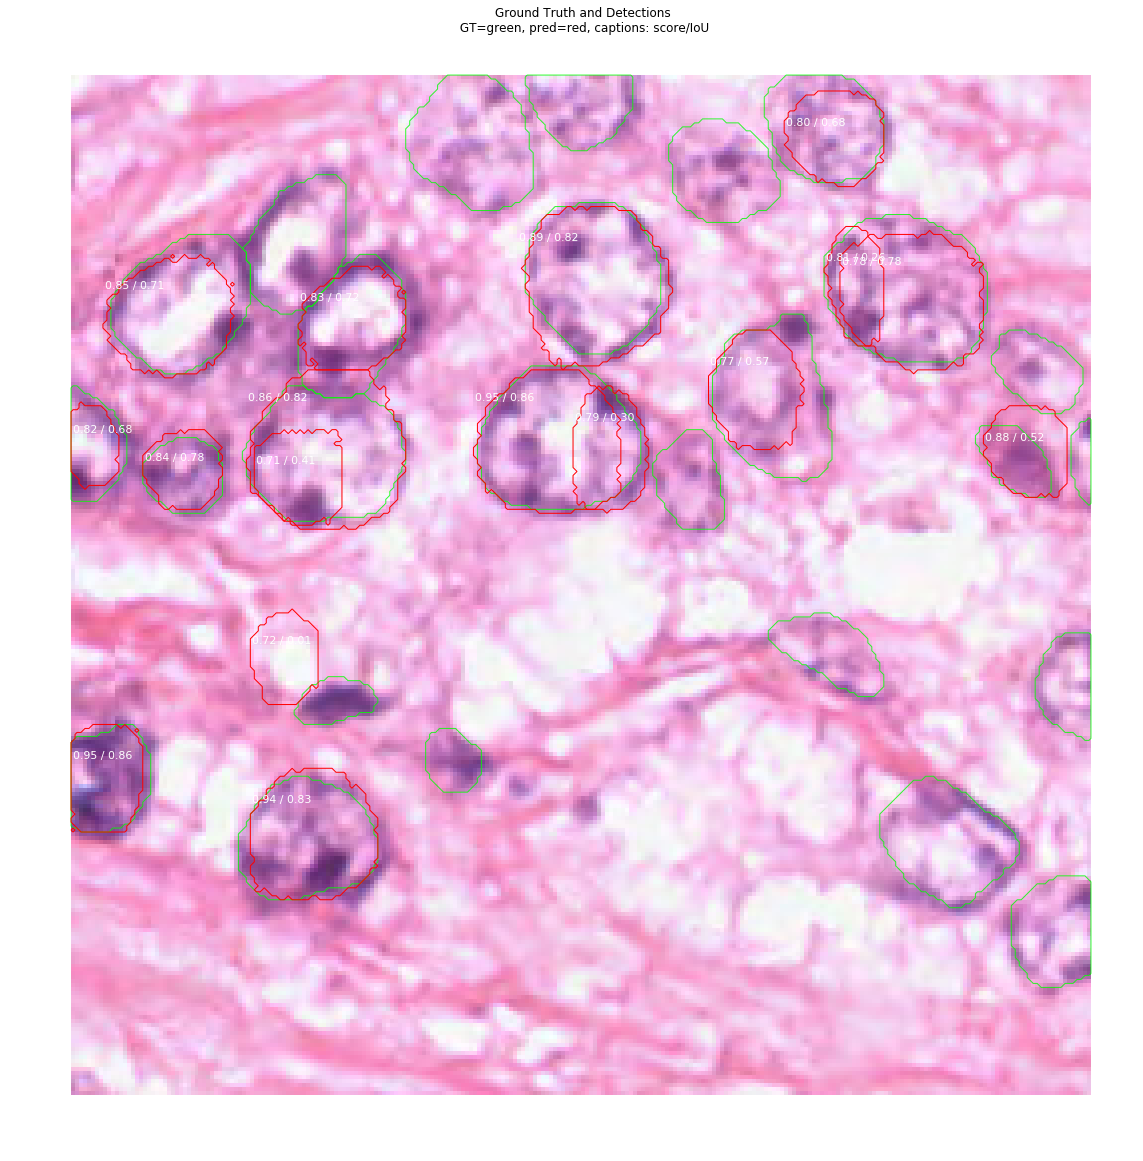

In [16]:
import skimage
import time
config.IMAGE_RESIZE_MODE = 'crop'
config.IMAGE_MIN_DIM = 256

%matplotlib inline

image_id = random.choice(dataset.image_ids)
image_id = 0
t0 = time.time()
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False, load_from_array=True)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])
t1 = time.time()
# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
t2 = time.time()
# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

t3 = time.time()

image ID: nuclear.TCGA-B0-5711-01Z-00-DX1 (1) TCGA-B0-5711-01Z-00-DX1
Original image shape:  [1000 1000    3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    1.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.04424  max:    1.01430  float32
proposals                shape: (196,)                min:    0.70467  max:    0.99607  float32
gt_class_id              shape: (342,)                min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (342, 4)              min:   12.00000  max: 1012.00000  int32
gt_mask                  shape: (1024, 1024, 342)     min:    0.00000  max:    1.00000  bool


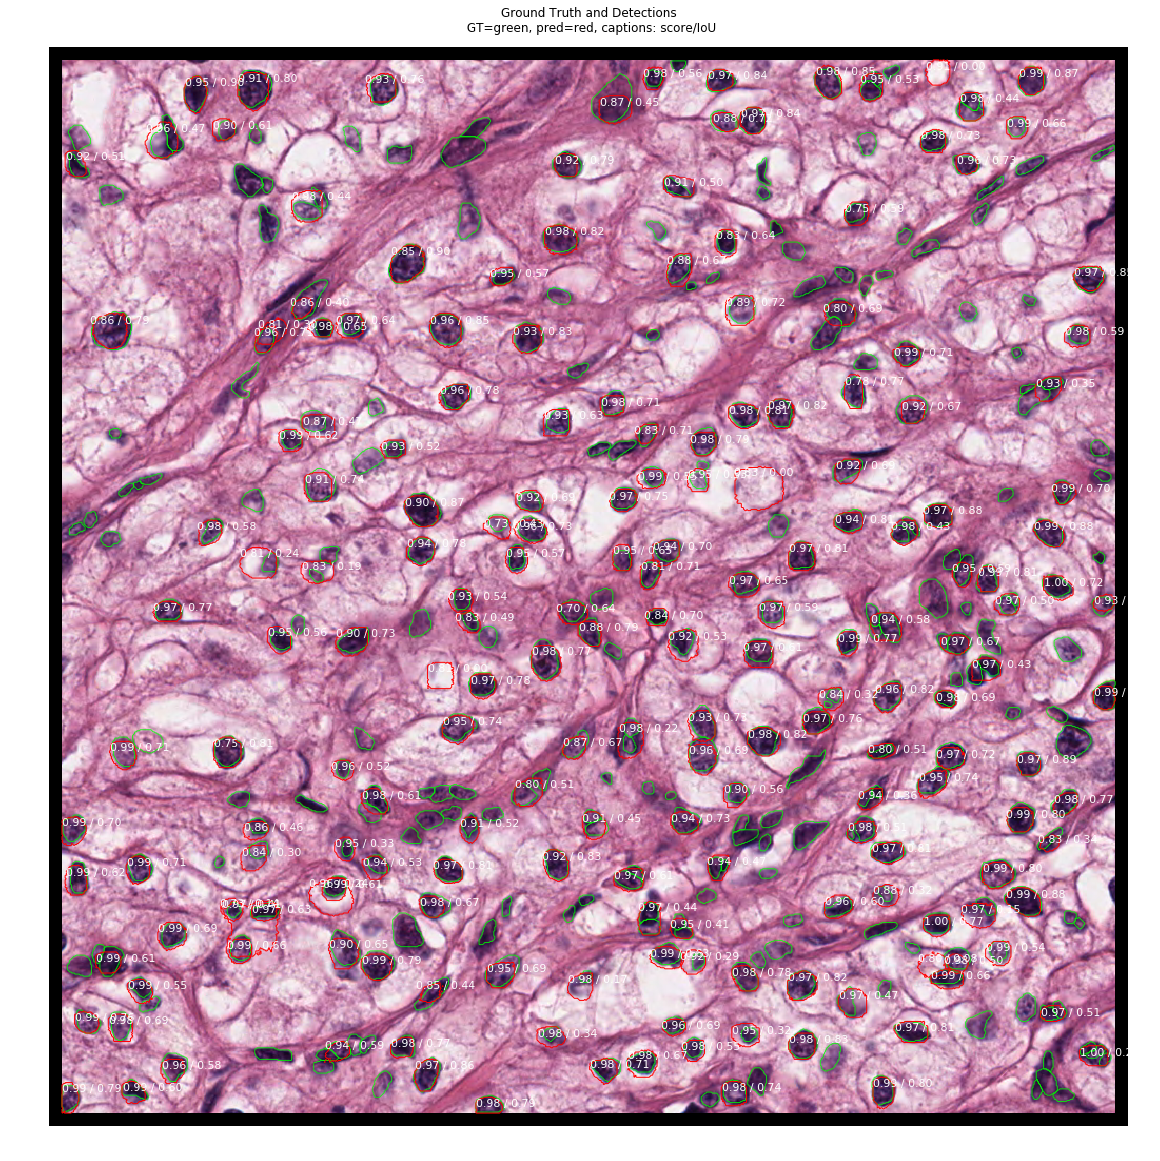

In [27]:
### import skimage
import time
config.IMAGE_RESIZE_MODE = 'pad64'

%matplotlib inline

image_id = random.choice(dataset.image_ids)
image_id = 1
t0 = time.time()
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False, load_from_array=True)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])
t1 = time.time()
# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0),
                              verbose=1)
t2 = time.time()
# Display results
r = results[0]
log("proposals", r['scores'])
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
# utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
#                        r['rois'], r['class_ids'], r['scores'], r['masks'],
#                        verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

t3 = time.time()

## measure result in AJI

In [28]:
gt_mask = gt_mask[12:1012, 12:1012, :]
gt_mask.shape

(1000, 1000, 342)

In [29]:
pred_mask = r['masks']
pred_mask = pred_mask[12:1012, 12:1012, :]

In [30]:
pred_mask.shape

(1000, 1000, 196)

In [31]:
gt_mask.shape

(1000, 1000, 342)

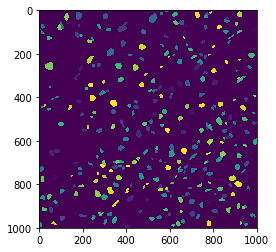

In [32]:
mask = np.zeros((1000,1000))
for i in range(gt_mask.shape[2]):
    mask[gt_mask[:,:,i]] = i + 1
mask = mask.astype('int16')
plt.imshow(mask)

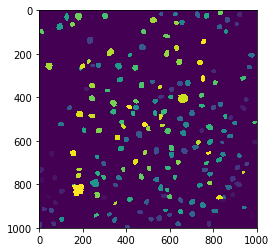

In [33]:
prediction = np.zeros((1000,1000))
for i in range(pred_mask.shape[2]):
    prediction[pred_mask[:,:,i]] = i + 1
prediction = prediction.astype('int16')
plt.imshow(prediction)

In [34]:
def agg_jc_index(mask, pred):
    from tqdm import tqdm_notebook
    """Calculate aggregated jaccard index for prediction & GT mask
    reference paper here: https://www.dropbox.com/s/j3154xgkkpkri9w/IEEE_TMI_NuceliSegmentation.pdf?dl=0

    mask: Ground truth mask, shape = [1000, 1000, instances]
    pred: Prediction mask, shape = [1000,1000], dtype = uint16, each number represent one instance

    Returns: Aggregated Jaccard index for GT & mask 
    """

    c = 0 # count intersection
    u = 0 # count union
    pred_instance = pred.max() # predcition instance number
    pred_mark_used = [] # mask used
    pred_mark_isused = np.zeros((pred_instance+1), dtype=bool)
    
    for idx_m in tqdm_notebook(range(len(mask[0,0,:]))):
        m = mask[:,:,idx_m]
        intersect_list = []
        union_list = []
        iou_list = []
        
        for idx_pred in range(1, pred_instance+1):
            # check the prediction has been used or not
            if pred_mark_isused[idx_pred] == True:
                intersect = 0
                union = np.count_nonzero(m!=0)
            else:
                p = (pred == idx_pred)
                
                # replace multiply with bool operation 
                intersect = np.count_nonzero((m!=0) & p)
                union = np.count_nonzero(m!=0) + np.count_nonzero(p) - intersect
            
            intersect_list.append(intersect)
            union_list.append(union)
            
        iou_list = np.array(intersect_list) / np.array(union_list)    
        hit_idx = np.argmax(np.array(iou_list))
        c += intersect_list[hit_idx]
        u += union_list[hit_idx]
        pred_mark_used.append(hit_idx)
        pred_mark_isused[hit_idx+1] = True
        
    pred_mark_used = [x+1 for x in pred_mark_used]
    pred_fp = set(np.unique(pred)) - {0} - set(pred_mark_used)
    pred_fp_pixel = np.sum([np.sum(pred==i) for i in pred_fp])

    u += pred_fp_pixel
    print (c / u)
    return (c / u)

In [35]:
result = agg_jc_index(gt_mask, prediction)


0.4212400796432878


In [ ]:
import scipy.io as sio

In [ ]:
sio.savemat('/home/jimmy15923/pred.mat', {"predicted_map":prediction})
sio.savemat('/home/jimmy15923/gt_mask.mat', {"gt_map":mask})

In [ ]:
prediction.shape

## Measure RPN

In [ ]:
config.IMAGE_RESIZE_MODE = 'crop'
config.IMAGE_MIN_DIM = 256

image_id = random.choice(dataset.image_ids)
image_id = 1

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False, load_from_array=True)
info = dataset.image_info[image_id]

# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [ ]:
limit = 200
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals_visual = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
proposals = rpn['proposals'][0, :2000] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals_visual)

In [ ]:
visualize.draw_boxes(image, refined_boxes=gt_bbox)

In [ ]:
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors_clipped'][0]* np.array([h, w, h, w]), gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))
print("Total GT bbox = {}".format(gt_bbox.shape))

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 200
ax = get_ax(1, 2)
visualize.draw_boxes(
    image, ax=ax[0],
    boxes=utils.denorm_boxes(rpn["pre_nms_anchors"][0, :limit], image.shape[:2]), 
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors"][0, :limit], image.shape[:2]))
visualize.draw_boxes(
    image, ax=ax[1],
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, :limit], image.shape[:2]))

In [ ]:
# Show refined anchors after non-max suppression
print("CONFIG of NMS THRESHOLD is {}".format(config.RPN_NMS_THRESHOLD))
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, ixs], image.shape[:2]))

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 100
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= 0.7)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
visualize.display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
import warnings
import scipy
def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.
    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if scale != 1:
            mask = cv2.imresize(mask*1, (0,0), fx=scale, fy=scale)
#             mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    if crop is not None:
        y, x, h, w = crop
        mask = mask[y:y + h, x:x + w]
    else:
        mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask


In [ ]:
# Load image and mask
%timeit
T = time.time()
dataset = dataset_val
image_id = np.random.choice(range(28))
image_id = 4
use_mini_mask=True
load_from_array=True
augment = False

if load_from_array:
    image = dataset.image_arr[image_id]
    mask, class_ids = dataset.load_mask_arr(dataset.mask_arr, image_id)
else:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

original_shape = image.shape


image, window, scale, padding, crop = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    min_scale=config.IMAGE_MIN_SCALE,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)

t = time.time()
mask = resize_mask(mask, scale, padding, crop)
print("TIME for resizing mask = ", time.time() - t)
# Random horizontal flips.
# TODO: will be removed in a future update in favor of augmentation
if augment:
    logging.warning("'augment' is depricated. Use 'augmentation' instead.")
    if random.randint(0, 1):
        image = np.fliplr(image)
        mask = np.fliplr(mask)

# Augmentation
# This requires the imgaug lib (https://github.com/aleju/imgaug)

t = time.time()
if augmentation:
    import imgaug

    # Augmentors that are safe to apply to masks
    # Some, such as Affine, have settings 
    # that make them unsafe, so always
    # test your augmentation on masks
    MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                       "Fliplr", "Flipud", "CropAndPad",
                       "Affine", "PiecewiseAffine"]

    def hook(images, augmenter, parents, default):
        """Determines which augmenters to apply to masks."""
        return (augmenter.__class__.__name__ in MASK_AUGMENTERS)

    # Store shapes before augmentation to compare
    image_shape = image.shape
    mask_shape = mask.shape
    # Make augmenters deterministic to apply similarly to images and masks
    det = augmentation.to_deterministic()
    image = det.augment_image(image)
    # Change mask to np.uint8 because imgaug doesn't support np.bool
    mask = det.augment_image(mask.astype(np.uint8),
                             hooks=imgaug.HooksImages(activator=hook))
    # Verify that shapes didn't change
    assert image.shape == image_shape, "Augmentation shouldn't change image size"
    assert mask.shape == mask_shape, "Augmentation shouldn't change mask size"
    # Change mask back to bool
    mask = mask.astype(np.bool)

print("TIME for augment = {}".format(time.time() - t))
# Note that some boxes might be all zeros if the corresponding mask got cropped out.
# and here is to filter them out

_idx = np.sum(mask, axis=(0, 1)) > 0

# 0.48
t = time.time()
print(mask.shape)
mask = mask[:,:, _idx]
print(mask.shape)
class_ids = class_ids[_idx]

# print(mask.shape)
# mask = mask.take(_idx, axis=2)
# print(mask.shape)
# class_ids = class_ids.take(_idx)

print("TIME of slice MASK = {}".format(time.time() - t))
# Bounding boxes. Note that some boxes might be all zeros
# if the corresponding mask got cropped out.
# bbox: [num_instances, (y1, x1, y2, x2)]
t = time.time()
bbox = utils.extract_bboxes(mask)

# Active classes
# Different datasets have different classes, so track the
# classes supported in the dataset of this image.
active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
active_class_ids[source_class_ids] = 1

# Resize masks to smaller size to reduce memory usage
print("RESIZE")
t = time.time()
if use_mini_mask:
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
print("MINI =", time.time() -t)
# Image meta data
image_meta = compose_image_meta(image_id, original_shape, image.shape,
                                window, scale, active_class_ids)
print("TOTAL = {}".format(time.time() - T))

In [ ]:
%load_ext line_profiler